In [1]:
from CasingSimulations import *
%matplotlib inline

## Compare against an electric dipole in a wholespace

In [2]:
from SimPEG.EM import Analytics

In [353]:
csx, ncx, npadx = 0.4, 20, 42
csz, ncz, npadz = 0.4, 6, 40

hx = Utils.meshTensor([(csx, ncx), (csx, npadx, 1.2)])
hz = Utils.meshTensor([(csz, npadz, -1.2), (csz, ncz), (csz, npadz, 1.2)])

In [354]:
mesh = Mesh.CylMesh([hx, 1., hz], x0='00C')

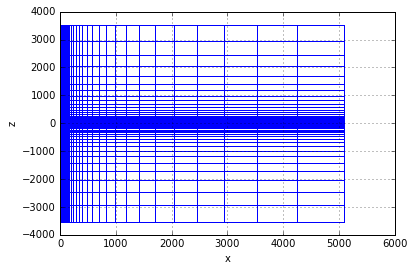

In [355]:
mesh.plotGrid()

In [356]:
src_ind = (
    (mesh.gridFz[:,0] < csx) &
    (mesh.gridFz[:,2] <= csz*3) &
    (mesh.gridFz[:,2] >= -csz*3)
)

In [357]:
src_vecz = np.zeros(mesh.vnF[2], dtype=complex)
src_vecz[src_ind] = 1. 

src_vec = np.hstack([
    np.zeros(mesh.vnF[0], dtype=complex),
    np.zeros(mesh.vnF[1], dtype=complex),
    src_vecz
])

(-20, 20.0)

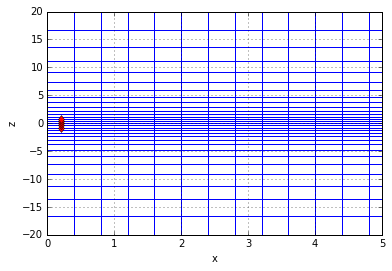

In [358]:
fig, ax = plt.subplots(1,1)

mesh.plotGrid(ax=ax)
ax.plot(mesh.gridFz[src_ind, 0], mesh.gridFz[src_ind, 2], 'rd')
ax.set_xlim([0., 5.])
ax.set_ylim([-20, 20.])

In [359]:
freq = 1. 

# mesh.getFaceInnerProduct(invMat=True) * src_vec
# src_vec / mesh.area

# src = FDEM.Src.RawVec_e([], freq,  mesh.getFaceInnerProduct(invMat=True) * src_vec)
src = FDEM.Src.RawVec_e([], freq,  (src_vec / mesh.area))

In [360]:
prob = FDEM.Problem3D_h(mesh, sigmaMap=Maps.IdentityMap(mesh),  mu=mu_0)
prob.solver = Solver
survey = FDEM.Survey([src])

prob.pair(survey)

In [361]:
sigma = 0.6
print('skin depth {}'.format(500/np.sqrt(sigma*freq)))
fields = prob.fields(sigma*np.ones(mesh.nC))

skin depth 645.497224368


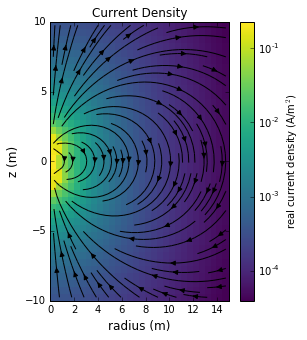

In [362]:
plotCurrentDensity(mesh, fields[src, 'j'], xmax = 15., zmin=10, zmax=-10, csz=0.5, csx=0.5)

In [363]:
# pick a line and compare to electric dipole analytic

jx = fields[src, 'j'][:mesh.nFx].reshape(mesh.vnFx[0], mesh.vnFx[2], order='F')
jz = fields[src, 'j'][mesh.nFx:].reshape(mesh.vnFz[0], mesh.vnFz[2], order='F')

In [364]:
length = mesh.gridFz[src_ind,2] 
length = length.max() - length.min() + mesh.hz.min()

In [365]:
# Look at Jz
x_ind = 40
XYZ = Utils.ndgrid([np.r_[mesh.vectorCCx[x_ind]], np.r_[1], mesh.vectorNz])
print XYZ.shape

# solve the analytic 
jana_x, jana_y, jana_z = Analytics.E_from_ElectricDipoleWholeSpace(XYZ, np.r_[0., 0., 0.], sig=sigma, f=np.r_[freq], current=1., length=length, orientation='Z')

jana_x, jana_y, jana_z = sigma*jana_x, sigma*jana_y, sigma*jana_z,

# plt.plot()

(87, 3)


0.00555031038347
0.994621600004


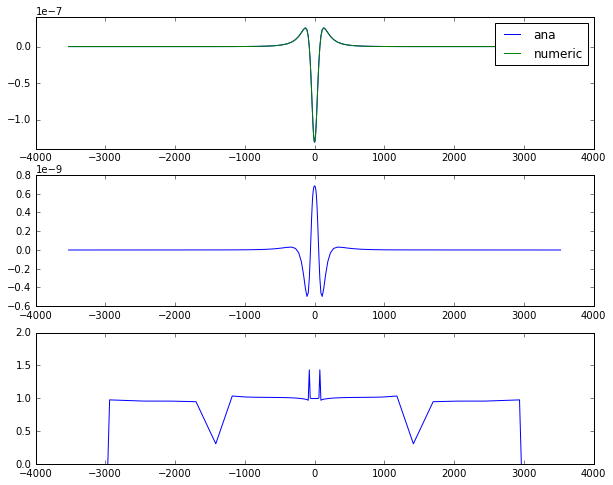

In [366]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))

ax[0].plot(mesh.vectorNz, jana_z.real)
ax[0].plot(mesh.vectorNz, jz[x_ind, :].real)
ax[0].legend(['ana', 'numeric'])

ax[1].plot(mesh.vectorNz, jz[x_ind, :].real - jana_z.real)

ax[2].plot(mesh.vectorNz, jz[x_ind, :].real / jana_z.real)
ax[2].set_ylim([0, 2])

print(np.linalg.norm(jz[x_ind, :].real - jana_z.real)/np.linalg.norm(jana_z.real))
print(np.linalg.norm(jz[x_ind, :].real)/np.linalg.norm(jana_z.real))

0.00852465738878
1.00840777675


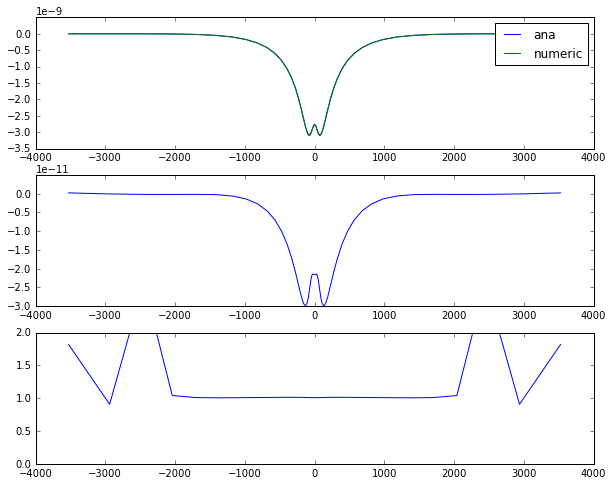

In [367]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))

ax[0].plot(mesh.vectorNz, jana_z.imag)
ax[0].plot(mesh.vectorNz, jz[x_ind, :].imag)
ax[0].legend(['ana', 'numeric'])

ax[1].plot(mesh.vectorNz, jz[x_ind, :].imag - jana_z.imag)

ax[2].plot(mesh.vectorNz, jz[x_ind, :].imag / jana_z.imag)
ax[2].set_ylim([0, 2])

print(np.linalg.norm(jz[x_ind, :].imag - jana_z.imag)/np.linalg.norm(jana_z.imag))
print(np.linalg.norm(jz[x_ind, :].imag)/np.linalg.norm(jana_z.imag))

In [344]:
# Look at Jx
z_ind = 15
print np.r_[mesh.vectorCCz[z_ind]]

XYZ = Utils.ndgrid([mesh.vectorNx, np.r_[1], np.r_[mesh.vectorCCz[z_ind]]])
print XYZ.shape

# solve the analytic 
jana_x, jana_y, jana_z = Analytics.E_from_ElectricDipoleWholeSpace(
    XYZ, np.r_[0., 0., 0.], sig=sigma, f=np.r_[freq], current=1., length=length, orientation='Z'
)

jana_x, jana_y, jana_z = sigma*jana_x, sigma*jana_y, sigma*jana_z,

# plt.plot()

[-207.87167662]
(62, 3)


0.104775603308
1.10334565094


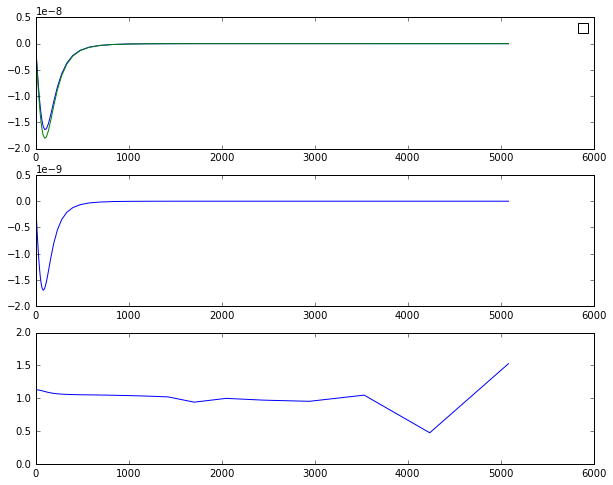

In [345]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))

ax[0].plot(mesh.vectorNx, jana_x.real)
ax[0].plot(mesh.vectorNx, jx[:, z_ind].real)
ax[0].legend('ana', 'numeric')

ax[1].plot(mesh.vectorNx, jx[:, z_ind].real - jana_x.real)

ax[2].plot(mesh.vectorNx, jx[:, z_ind].real / jana_x.real)
ax[2].set_ylim([0, 2])

print(np.linalg.norm(jx[:, z_ind].real - jana_x.real)/np.linalg.norm(jana_x.real))
print(np.linalg.norm(jx[:, z_ind].real)/np.linalg.norm(jana_x.real))

0.0958413824666
1.09544912566


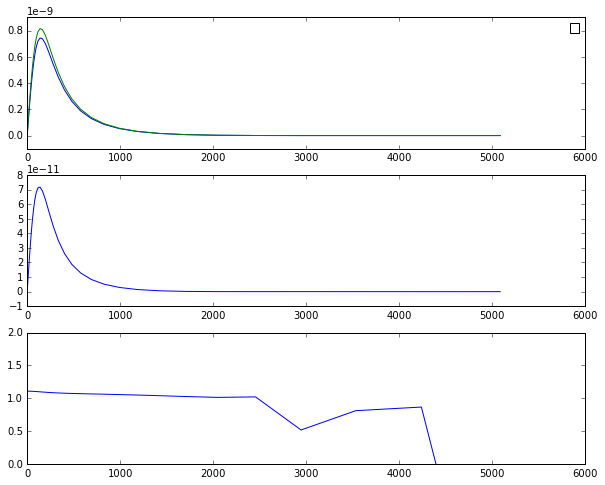

In [346]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))

ax[0].plot(mesh.vectorNx, jana_x.imag)
ax[0].plot(mesh.vectorNx, jx[:, z_ind].imag)
ax[0].legend('ana', 'numeric')

ax[1].plot(mesh.vectorNx, jx[:, z_ind].imag - jana_x.imag)

ax[2].plot(mesh.vectorNx, jx[:, z_ind].imag / jana_x.imag)
ax[2].set_ylim([0, 2])

print(np.linalg.norm(jx[:, z_ind].imag - jana_x.imag)/np.linalg.norm(jana_x.imag))
print(np.linalg.norm(jx[:, z_ind].imag)/np.linalg.norm(jana_x.imag))